In [1]:
import os

import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.__version__)

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

Num GPUs Available:  1
2.7.0


In [2]:
FRAME_SIZE = 30

## Split and shuffle data

In [3]:
directory = "recordings_converted"

# load all file names and generate paths
all_raw_data_files = os.listdir(directory)
all_raw_data_paths = [os.path.join(directory, raw_data_file) for raw_data_file in all_raw_data_files]

np.random.shuffle(all_raw_data_paths)

# Calculate number of files on each dataset
num_train_files = int(0.8 * len(all_raw_data_paths))
num_valid_files = int(0.1 * len(all_raw_data_paths))

# Split all data into train,valid and test set
train_ls = all_raw_data_paths[:num_train_files]
valid_ls = all_raw_data_paths[num_train_files:num_train_files + num_valid_files]
test_ls = all_raw_data_paths[num_train_files + num_valid_files:]

print('Raw files: {}'.format(len(all_raw_data_paths)))

print('Training set: {}'.format(len(train_ls)))
print('Validation set: {}'.format(len(valid_ls)))
print('Test set: {}'.format(len(test_ls)))

Raw files: 1990
Training set: 1592
Validation set: 199
Test set: 199


## Plot raw mfcc

Raw data shape: (9436,)
Selected utterance length: 30
Shape of MFCC features before cutting or padding: (20, 19)


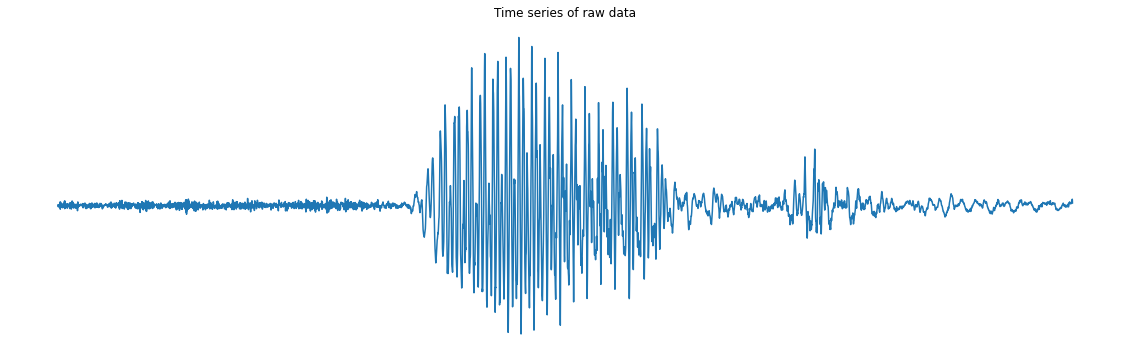

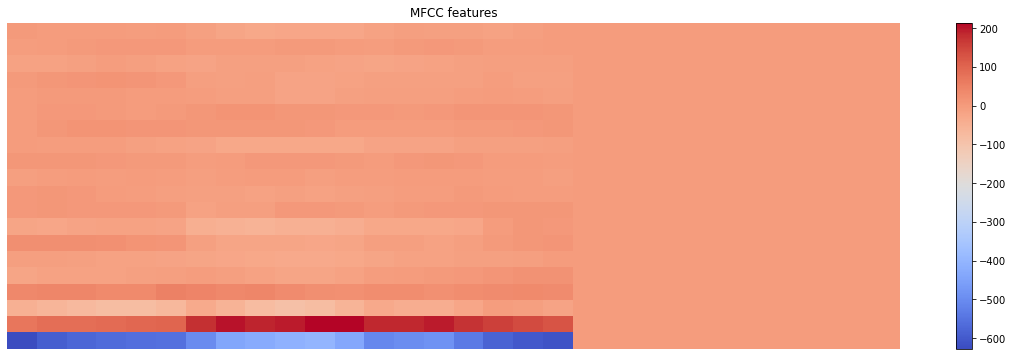

In [4]:
#Get raw .wav data and sampling rate from librosa's load function
raw_w, sampling_rate = librosa.load(train_ls[5], mono=True)
    
print('Raw data shape: {}'.format(raw_w.shape))
    
#Obtain MFCC Features from raw data
mfcc_features = librosa.feature.mfcc(y=raw_w, sr=sampling_rate)
    
print('Selected utterance length: {}'.format(FRAME_SIZE))
print('Shape of MFCC features before cutting or padding: {}'.format(mfcc_features.shape))
    
#Cut or pad
if mfcc_features.shape[1] > FRAME_SIZE:
    mfcc_features = mfcc_features[:, :FRAME_SIZE]
else:
    mfcc_features = np.pad(mfcc_features, ((0, 0), (0, FRAME_SIZE - mfcc_features.shape[1])),
                                   mode='constant', constant_values=0)
#Visualize of raw data
fig, ax = plt.subplots(1, figsize=(20, 6))
ax.set_axis_off()
plt.plot(raw_w)
plt.title('Time series of raw data')
plt.show()

#Visualize of extracted mfcc features
fig, ax = plt.subplots(1, figsize=(20, 6))
ax.set_axis_off()

librosa.display.specshow(mfcc_features)
plt.title('MFCC features')
plt.colorbar()
plt.show()

## Extract mfcc features and labels

In [5]:
def extract_mfcc_features_labels(file_paths, frame_size):
    """ Extract MFCC features and labels of all raw data

    Args:
    file_paths: List of paths of raw files.
    frame_size: Length of data to cut or pad.

    Returns:
    all_mfcc_features: 2D array, shape: (number of samples, number of mfcc features)
    all_labels: 2D array, shape: (number of samples, number of labels)
    """
    # Initialize the results
    all_mfcc_features = []
    all_labels = []

    # For loop through all files' paths
    for file_path in file_paths:
        
        # Get raw .wav data and sampling rate from librosa's load function
        raw_w, sampling_rate = librosa.load(file_path, mono=True)
    
        # Obtain MFCC Features from raw data
        mfcc_features = librosa.feature.mfcc(y=raw_w, sr=sampling_rate)
    
        # Cut or pad
        if mfcc_features.shape[1] > frame_size:
            mfcc_features = mfcc_features[:, :frame_size]
        else:
            mfcc_features = np.pad(mfcc_features, ((0, 0), (0, frame_size - mfcc_features.shape[1])),
                                   mode='constant', constant_values=0)
            
        mfcc_features = mfcc_features.flatten()

        # Extract labels from file names.
        basename = os.path.basename(file_path)

        # One-hot encoding for labels
        raw_label = int(basename.split('_')[0])
        label = np.eye(10)[raw_label]

        all_mfcc_features.append(mfcc_features)
        all_labels.append(label)

    # Convert results from list of arrays to 2d arrays
    all_mfcc_features = np.asarray(all_mfcc_features)
    all_labels = np.asarray(all_labels)

    print('all_mfcc_features: {}'.format(all_mfcc_features.shape))
    print('all_labels: {}'.format(all_labels.shape))

    return all_mfcc_features, all_labels

In [6]:
print('Extract training set...')
train_mfcc, train_label = extract_mfcc_features_labels(train_ls, FRAME_SIZE)

print('Extract validation set...')
valid_mfcc, valid_label = extract_mfcc_features_labels(valid_ls, FRAME_SIZE)

print('Extract test set...')
test_mfcc, test_label = extract_mfcc_features_labels(test_ls,FRAME_SIZE)

Extract training set...
all_mfcc_features: (1592, 600)
all_labels: (1592, 10)
Extract validation set...
all_mfcc_features: (199, 600)
all_labels: (199, 10)
Extract test set...
all_mfcc_features: (199, 600)
all_labels: (199, 10)


In [7]:
def build_model(input_shape, hidden_sizes, num_classes):
    """ 
    Build model given input shape, hidden sizes and number of classes. 

    Args:
    input_shape: Tuple
    hidden_sizes: List of ints
    num_classes: number of classes/labels to output.

    Return:
    Tensorfow Model
    """

    # Initialize the model
    model = tf.keras.Sequential(name='Speech_model')

    # Build hidden layers  dense softmax
    for i, hidden_size in enumerate(hidden_sizes):
        if i == 0:
            hidden_layer = tf.keras.layers.Dense(units=hidden_size, activation='tanh', input_dim=input_shape[1])
        else:
            hidden_layer = tf.keras.layers.Dense(units=hidden_size, activation='tanh')
        model.add(hidden_layer)

    # Build output layer
    output_layer = tf.keras.layers.Dense(units=num_classes, activation='softmax', name='output_layer')
    model.add(output_layer)

    # Print model summary
    print(model.summary())

    return model

In [8]:
train_mfcc.shape

(1592, 600)

In [17]:
model = build_model(input_shape=train_mfcc.shape, hidden_sizes=[4096, 1024, 128], num_classes=10)

Model: "Speech_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 4096)              2461696   
                                                                 
 dense_5 (Dense)             (None, 1024)              4195328   
                                                                 
 dense_6 (Dense)             (None, 128)               131200    
                                                                 
 output_layer (Dense)        (None, 10)                1290      
                                                                 
Total params: 6,789,514
Trainable params: 6,789,514
Non-trainable params: 0
_________________________________________________________________
None


## Compile model

In [18]:
model.compile(optimizer = tf.optimizers.Nadam(learning_rate=0.00001),
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=[tf.keras.metrics.categorical_accuracy])

In [19]:
def train_model(model, train_x, train_y, valid_x, valid_y, epochs, verbose, model_save_path, patience):
    # Reduce learning rate if plateu 
    lr_monitor = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=10, factor=0.5, cooldown=1)
    
    # Save the best weights during the training process
    model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=model_save_path, save_best_only=True)

    # Stop the training when validation loss starts increasing
    early_stop = tf.keras.callbacks.EarlyStopping(patience=patience, monitor="val_loss")

    # Train model
    history = model.fit(
        x=train_x, 
        y=train_y, 
        epochs=epochs, 
        verbose=verbose,
        callbacks=[lr_monitor, model_checkpoint, early_stop],
        validation_data=(valid_x, valid_y)
    )

    return model, history

In [20]:
model, history = train_model(model, train_mfcc, train_label, valid_mfcc, valid_label, 
                             epochs=5000,
                             verbose=1,
                             model_save_path="save/model.h5", 
                             patience=20)

Epoch 1/5000
50/50 [==============================] - 2s 25ms/step - loss: 1.9669 - categorical_accuracy: 0.3681 - val_loss: 1.5978 - val_categorical_accuracy: 0.5477 - lr: 1.0000e-05
Epoch 2/5000
50/50 [==============================] - 1s 21ms/step - loss: 1.1739 - categorical_accuracy: 0.7268 - val_loss: 1.2293 - val_categorical_accuracy: 0.6784 - lr: 1.0000e-05
Epoch 3/5000
50/50 [==============================] - 1s 22ms/step - loss: 0.8473 - categorical_accuracy: 0.8285 - val_loss: 1.0090 - val_categorical_accuracy: 0.7538 - lr: 1.0000e-05
Epoch 4/5000
50/50 [==============================] - 1s 21ms/step - loss: 0.6507 - categorical_accuracy: 0.8932 - val_loss: 0.8589 - val_categorical_accuracy: 0.8191 - lr: 1.0000e-05
Epoch 5/5000
50/50 [==============================] - 1s 21ms/step - loss: 0.5177 - categorical_accuracy: 0.9328 - val_loss: 0.7456 - val_categorical_accuracy: 0.8543 - lr: 1.0000e-05
Epoch 6/5000
50/50 [==============================] - 1s 21ms/step - loss: 0.420

50/50 [==============================] - 1s 18ms/step - loss: 0.0142 - categorical_accuracy: 1.0000 - val_loss: 0.1693 - val_categorical_accuracy: 0.9548 - lr: 1.0000e-05
Epoch 46/5000
50/50 [==============================] - 1s 21ms/step - loss: 0.0136 - categorical_accuracy: 1.0000 - val_loss: 0.1662 - val_categorical_accuracy: 0.9548 - lr: 1.0000e-05
Epoch 47/5000
50/50 [==============================] - 1s 22ms/step - loss: 0.0130 - categorical_accuracy: 1.0000 - val_loss: 0.1602 - val_categorical_accuracy: 0.9598 - lr: 1.0000e-05
Epoch 48/5000
50/50 [==============================] - 1s 18ms/step - loss: 0.0125 - categorical_accuracy: 1.0000 - val_loss: 0.1604 - val_categorical_accuracy: 0.9497 - lr: 1.0000e-05
Epoch 49/5000
50/50 [==============================] - 1s 21ms/step - loss: 0.0120 - categorical_accuracy: 1.0000 - val_loss: 0.1590 - val_categorical_accuracy: 0.9598 - lr: 1.0000e-05
Epoch 50/5000
50/50 [==============================] - 1s 21ms/step - loss: 0.0115 - cate

50/50 [==============================] - 1s 18ms/step - loss: 0.0031 - categorical_accuracy: 1.0000 - val_loss: 0.1117 - val_categorical_accuracy: 0.9648 - lr: 1.0000e-05
Epoch 90/5000
50/50 [==============================] - 1s 20ms/step - loss: 0.0030 - categorical_accuracy: 1.0000 - val_loss: 0.1093 - val_categorical_accuracy: 0.9698 - lr: 1.0000e-05
Epoch 91/5000
50/50 [==============================] - 1s 20ms/step - loss: 0.0029 - categorical_accuracy: 1.0000 - val_loss: 0.1091 - val_categorical_accuracy: 0.9698 - lr: 1.0000e-05
Epoch 92/5000
50/50 [==============================] - 1s 20ms/step - loss: 0.0028 - categorical_accuracy: 1.0000 - val_loss: 0.1072 - val_categorical_accuracy: 0.9698 - lr: 1.0000e-05
Epoch 93/5000
50/50 [==============================] - 1s 18ms/step - loss: 0.0027 - categorical_accuracy: 1.0000 - val_loss: 0.1084 - val_categorical_accuracy: 0.9648 - lr: 1.0000e-05
Epoch 94/5000
50/50 [==============================] - 1s 20ms/step - loss: 0.0026 - cate

50/50 [==============================] - 1s 21ms/step - loss: 9.4129e-04 - categorical_accuracy: 1.0000 - val_loss: 0.0858 - val_categorical_accuracy: 0.9698 - lr: 1.0000e-05
Epoch 134/5000
50/50 [==============================] - 1s 21ms/step - loss: 9.1661e-04 - categorical_accuracy: 1.0000 - val_loss: 0.0852 - val_categorical_accuracy: 0.9698 - lr: 1.0000e-05
Epoch 135/5000
50/50 [==============================] - 1s 19ms/step - loss: 8.9628e-04 - categorical_accuracy: 1.0000 - val_loss: 0.0857 - val_categorical_accuracy: 0.9749 - lr: 1.0000e-05
Epoch 136/5000
50/50 [==============================] - 1s 18ms/step - loss: 8.7463e-04 - categorical_accuracy: 1.0000 - val_loss: 0.0858 - val_categorical_accuracy: 0.9698 - lr: 1.0000e-05
Epoch 137/5000
50/50 [==============================] - 1s 20ms/step - loss: 8.5362e-04 - categorical_accuracy: 1.0000 - val_loss: 0.0836 - val_categorical_accuracy: 0.9749 - lr: 1.0000e-05
Epoch 138/5000
50/50 [==============================] - 1s 18ms/s

50/50 [==============================] - 1s 21ms/step - loss: 3.3291e-04 - categorical_accuracy: 1.0000 - val_loss: 0.0716 - val_categorical_accuracy: 0.9749 - lr: 1.0000e-05
Epoch 177/5000
50/50 [==============================] - 1s 18ms/step - loss: 3.2518e-04 - categorical_accuracy: 1.0000 - val_loss: 0.0731 - val_categorical_accuracy: 0.9749 - lr: 1.0000e-05
Epoch 178/5000
50/50 [==============================] - 1s 18ms/step - loss: 3.1795e-04 - categorical_accuracy: 1.0000 - val_loss: 0.0722 - val_categorical_accuracy: 0.9749 - lr: 1.0000e-05
Epoch 179/5000
50/50 [==============================] - 1s 18ms/step - loss: 3.1046e-04 - categorical_accuracy: 1.0000 - val_loss: 0.0731 - val_categorical_accuracy: 0.9749 - lr: 1.0000e-05
Epoch 180/5000
50/50 [==============================] - 1s 18ms/step - loss: 3.0308e-04 - categorical_accuracy: 1.0000 - val_loss: 0.0716 - val_categorical_accuracy: 0.9749 - lr: 1.0000e-05
Epoch 181/5000
50/50 [==============================] - 1s 20ms/s

50/50 [==============================] - 1s 18ms/step - loss: 1.2332e-04 - categorical_accuracy: 1.0000 - val_loss: 0.0655 - val_categorical_accuracy: 0.9749 - lr: 1.0000e-05
Epoch 220/5000
50/50 [==============================] - 1s 18ms/step - loss: 1.2057e-04 - categorical_accuracy: 1.0000 - val_loss: 0.0645 - val_categorical_accuracy: 0.9799 - lr: 1.0000e-05
Epoch 221/5000
50/50 [==============================] - 1s 17ms/step - loss: 1.1799e-04 - categorical_accuracy: 1.0000 - val_loss: 0.0657 - val_categorical_accuracy: 0.9698 - lr: 1.0000e-05
Epoch 222/5000
50/50 [==============================] - 1s 18ms/step - loss: 1.1525e-04 - categorical_accuracy: 1.0000 - val_loss: 0.0650 - val_categorical_accuracy: 0.9698 - lr: 1.0000e-05
Epoch 223/5000
50/50 [==============================] - 1s 18ms/step - loss: 1.1265e-04 - categorical_accuracy: 1.0000 - val_loss: 0.0654 - val_categorical_accuracy: 0.9749 - lr: 1.0000e-05
Epoch 224/5000
50/50 [==============================] - 1s 21ms/s

50/50 [==============================] - 1s 18ms/step - loss: 4.7161e-05 - categorical_accuracy: 1.0000 - val_loss: 0.0607 - val_categorical_accuracy: 0.9698 - lr: 1.0000e-05
Epoch 263/5000
50/50 [==============================] - 1s 18ms/step - loss: 4.6129e-05 - categorical_accuracy: 1.0000 - val_loss: 0.0605 - val_categorical_accuracy: 0.9698 - lr: 1.0000e-05
Epoch 264/5000
50/50 [==============================] - 1s 17ms/step - loss: 4.5141e-05 - categorical_accuracy: 1.0000 - val_loss: 0.0613 - val_categorical_accuracy: 0.9698 - lr: 1.0000e-05
Epoch 265/5000
50/50 [==============================] - 1s 17ms/step - loss: 4.4168e-05 - categorical_accuracy: 1.0000 - val_loss: 0.0608 - val_categorical_accuracy: 0.9698 - lr: 1.0000e-05
Epoch 266/5000
50/50 [==============================] - 1s 18ms/step - loss: 4.3174e-05 - categorical_accuracy: 1.0000 - val_loss: 0.0608 - val_categorical_accuracy: 0.9698 - lr: 1.0000e-05
Epoch 267/5000
50/50 [==============================] - 1s 20ms/s

## Load trained model

In [21]:
model = tf.keras.models.load_model("save/model.h5")

## Visualize loss and accuracy

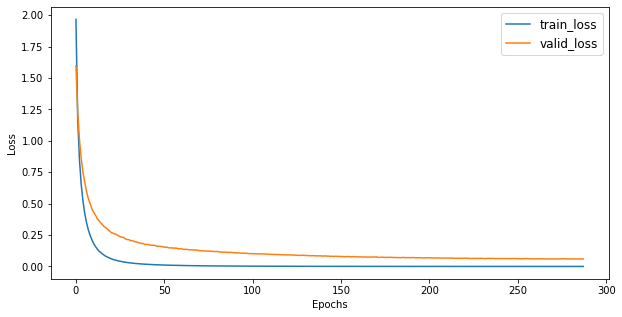

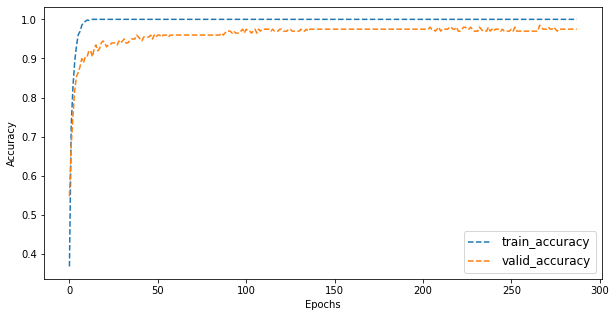

In [22]:
#Get loss and accuracy on training set
train_loss = history.history['loss']
train_acc = history.history['categorical_accuracy']

#Get loss and accuracy on training set
valid_loss = history.history['val_loss']
valid_acc = history.history['val_categorical_accuracy']

#Get training epochs
num_epochs = len(train_loss)

fig, ax = plt.subplots(1, figsize=(10, 5))
plt.plot(train_loss)
plt.plot(valid_loss)
plt.legend(['train_loss', 'valid_loss'], fontsize='large')
plt.xlabel('Epochs')
plt.ylabel('Loss')

fig, ax = plt.subplots(1, figsize=(10, 5))
plt.plot(train_acc, linestyle='--')
plt.plot(valid_acc, linestyle='--')
plt.legend(['train_accuracy', 'valid_accuracy'], fontsize='large')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

## Evaluate model

In [23]:
loss, acc = model.evaluate(test_mfcc, test_label)

print('Test loss: {}'.format(loss))
print('Test accuracy: {}'.format(acc))

7/7 [==============================] - 0s 6ms/step - loss: 0.0982 - categorical_accuracy: 0.9799
Test loss: 0.09824275225400925
Test accuracy: 0.979899525642395


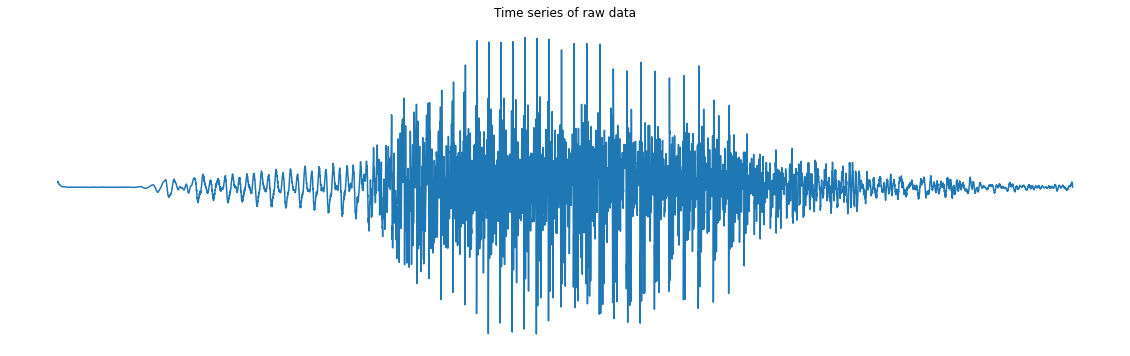

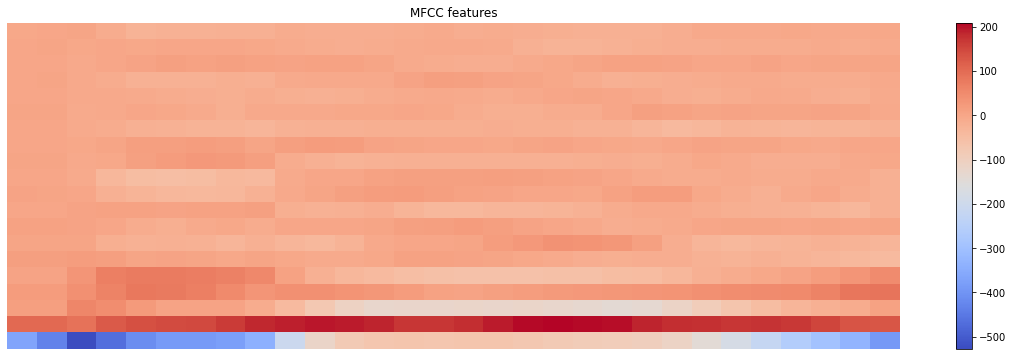

File loaded: chunk9.wav
Predicted label: 9


In [24]:
FILE_PATH = test_ls[9]

FILE_PATH = "chunk9.wav"

#Get raw .wav data, sampling rate from librosa's load function
raw_w, sampling_rate = librosa.load(FILE_PATH, mono=True)
    
#Obtain MFCC Features from raw data
mfcc_features = librosa.feature.mfcc(y=raw_w, sr=sampling_rate)

#Cut or pad
if mfcc_features.shape[1] > FRAME_SIZE:
    mfcc_features = mfcc_features[:, :FRAME_SIZE]
else:
    mfcc_features = np.pad(mfcc_features, 
                           ((0, 0), (0, FRAME_SIZE - mfcc_features.shape[1])),
                           mode='constant', 
                           constant_values=0)
    
#Visualize raw data
fig, ax = plt.subplots(1, figsize=(20, 6))
ax.set_axis_off()
plt.plot(raw_w)
plt.title('Time series of raw data')
plt.show()

#Visualize extracted mfcc features
fig, ax = plt.subplots(1, figsize=(20, 6))
ax.set_axis_off()

librosa.display.specshow(mfcc_features)
plt.title('MFCC features')
plt.colorbar()
plt.show()

#Extract MFCC features from single file path
mfcc_features = mfcc_features.flatten()

# Reshape mfcc_features to meet the requirements 1D numpy array, shape: (1, mfcc features)
mfcc_features = mfcc_features.reshape((1, -1))

#Predict label
pred_label = np.argmax(model.predict(mfcc_features))

print('File loaded: {}'.format(FILE_PATH))
print('Predicted label: {}'.format(pred_label))

